# RNN for trasnfer function prediction by Seq2Seq model

In [148]:
import torch 
import pandas as pd 
import pickle
import numpy as np
import os
import sys 

from torch.utils.data import Dataset, DataLoader
from torch import nn
import torch.nn.functional as F
import torch.optim as optim


import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from tqdm import trange

sns.set_theme()

In [149]:
path = r'FLAC\FLAC2D\1D 1 Column\Results'

In [150]:
# Load data
freq_data = np.genfromtxt(os.path.join(path,"TTF_freq.csv"), delimiter=",")

# Load pickle
with open(os.path.join(path,"TTF_data.pt"), "rb") as f:
    TTF_data = pickle.load(f)

with open(os.path.join(path,"Vs_values.pt"), "rb") as f:
    Vs_data = pickle.load(f)

TTF_data = np.array(TTF_data)
Vs_data = np.array(Vs_data)

# Get Vs_data less than 800
index = Vs_data <= 800
TTF_data = TTF_data[index]
Vs_data = Vs_data[index]

print(TTF_data.shape, Vs_data.shape,freq_data.shape)


(146, 1000) (146,) (1000,)


Text(0.5, 1.0, 'Vs = 143.29 m/s')

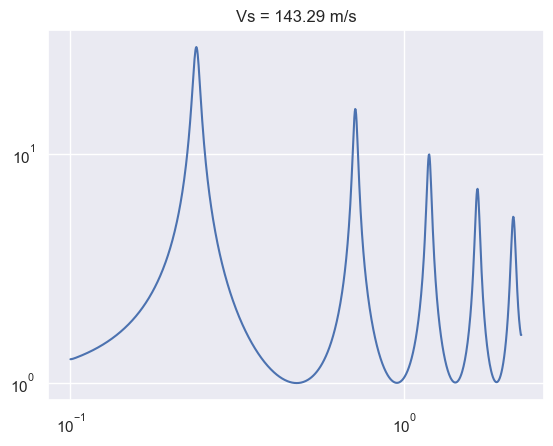

In [151]:
normalized_TTF_data = False

if normalized_TTF_data:
    TTF_values = normalization(TTF_data)
else:
    TTF_values = TTF_data

plt.loglog(freq_data, TTF_values[9,:], label="TTF")
plt.title(f"Vs = {Vs_data[9]:.2f} m/s")

In [152]:
class TTF_dataset(Dataset):
    def __init__(self, TTF_values, Vs_values):
        self.TTF_values = TTF_values
        self.Vs_values = Vs_values
        
    def __len__(self):
        return len(self.TTF_values)
    
    def __getitem__(self, idx):

        input_data = self.Vs_values[idx] * np.ones(30)
        input_data = torch.tensor(input_data, dtype=torch.float32).unsqueeze(1)

        target_data = self.TTF_values[idx]
        target_data = torch.tensor(target_data, dtype=torch.float32)
        return input_data, target_data

In [153]:
dataset = TTF_dataset(TTF_values, Vs_data)
print("Sizes in the dataset: ", len(dataset))
print("Data shapes for input and target: ", dataset[0][0].shape, dataset[0][1].shape)

# Separate into training and testing
train_size = int(0.8 * len(dataset))
val_size = (len(dataset) - train_size) // 2
test_size = len(dataset) - train_size - val_size
print("Train, validation and test sizes: " ,train_size, val_size, test_size)

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

batch_size = 50
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
print("Number of batches: ", len(train_loader), len(val_loader), len(test_loader))

Sizes in the dataset:  146
Data shapes for input and target:  torch.Size([30, 1]) torch.Size([1000])
Train, validation and test sizes:  116 15 15
Number of batches:  3 1 1


# Model

## MLP

In [154]:
# Create Model
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, hidden_layers, output_dim=1, activation=nn.ReLU, batch_norm=False):
        super(MLP, self).__init__()
        self.hidden_layers = nn.ModuleList()
        self.batch_norm = batch_norm
        self.activation = activation
        self.output_dim = output_dim

        # Input layer
        self.hidden_layers.append(nn.Linear(input_dim, hidden_dim))
        if self.batch_norm:
            self.hidden_layers.append(nn.BatchNorm1d(hidden_dim))

        # Hidden layers
        for _ in range(hidden_layers - 1):
            self.hidden_layers.append(nn.Linear(hidden_dim, hidden_dim))
            if self.batch_norm:
                self.hidden_layers.append(nn.BatchNorm1d(hidden_dim))

        # Output layer
        self.out = nn.Linear(hidden_dim, output_dim)


    def forward(self, x):
        for layer in self.hidden_layers:
            if isinstance(layer, nn.Linear):
                x = layer(x)
                x = self.activation()(x)
            elif isinstance(layer, nn.BatchNorm1d):
                x = layer(x)
        x = self.out(x)
        return x

## CNN1D

In [155]:
class CNN_1D(nn.Module):
    def __init__(self, input_size, kernel_size, hidden_dim, hidden_layers, output_dim=1, activation=nn.ReLU):
        super(CNN_1D, self).__init__()
        self.hidden_layers = nn.ModuleList()
        self.activation = activation
        self.output_dim = output_dim

        # Input layer
        self.hidden_layers.append(nn.Conv1d(input_size, hidden_dim, kernel_size))
        self.hidden_layers.append(nn.MaxPool1d(2))

        # Additional hidden layers
        for _ in range(hidden_layers - 1):
            self.hidden_layers.append(nn.Conv1d(hidden_dim, hidden_dim, kernel_size))
            self.hidden_layers.append(nn.MaxPool1d(2))

        # Adaptive pooling layer to reduce sequence length to 1
        self.hidden_layers.append(nn.AdaptiveAvgPool1d(1))

    def forward(self, x):
        for layer in self.hidden_layers:
            x = layer(x)
            x = self.activation()(x)
        return x

In [156]:
class Decoder_CNN_1D(nn.Module):
    def __init__(self, input_size, kernel_size, hidden_dim, hidden_layers, output_dim=1, activation=nn.ReLU):
        super(Decoder_CNN_1D, self).__init__()
        self.hidden_layers = nn.ModuleList()
        self.activation = activation()
        self.output_dim = output_dim

        # Input layer
        self.hidden_layers.append(nn.ConvTranspose1d(input_size, hidden_dim, kernel_size))
        self.hidden_layers.append(nn.Upsample(scale_factor=2))

        # Additional hidden layers
        for _ in range(hidden_layers - 1):
            self.hidden_layers.append(nn.ConvTranspose1d(hidden_dim, hidden_dim, kernel_size))
            self.hidden_layers.append(nn.Upsample(scale_factor=2))

        # Final upsampling layer to achieve the exact sequence length
        self.hidden_layers.append(nn.Upsample(scale_factor=1.25))

        # Output layer
        self.hidden_layers.append(nn.Conv1d(hidden_dim, output_dim, kernel_size))

    def forward(self, x):
        for layer in self.hidden_layers:
            x = layer(x)
            if isinstance(layer, (nn.ConvTranspose1d, nn.Conv1d)):
                x = self.activation(x)
        return x

## Attention

Based on Bahdanou

In [157]:
class BahdanauAttention(nn.Module):
    def __init__(self, hidden_dim):
        super(BahdanauAttention, self).__init__()
        self.hidden_dim = hidden_dim
        self.attn = nn.Linear(hidden_dim * 2, hidden_dim)  # Linear layer for attention
        self.v = nn.Parameter(torch.rand(hidden_dim))  # Learnable parameter vector

    def forward(self, hidden, encoder_outputs):
        batch_size = encoder_outputs.size(0)
        seq_len = encoder_outputs.size(1)
        
        # Expand hidden state to match the sequence length
        hidden = hidden.unsqueeze(1).repeat(1, seq_len, 1)
        
        # Compute energy scores
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim=2)))
        
        # Permute energy scores for batch matrix multiplication
        energy = energy.permute(0, 2, 1)
        
        # Repeat attention vector for batch size
        v = self.v.repeat(batch_size, 1).unsqueeze(1)
        
        # Compute attention weights
        attention_weights = torch.bmm(v, energy).squeeze(1)
        
        # Normalize attention weights
        return F.softmax(attention_weights, dim=1)

In [158]:
class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.attn = nn.Linear(hidden_size * 2, hidden_size)
        self.v = nn.Parameter(torch.rand(hidden_size))

    def forward(self, hidden, encoder_outputs):
        timestep = encoder_outputs.size(1)
        h = hidden.repeat(timestep, 1, 1).transpose(0, 1)
        attn_energies = self.score(h, encoder_outputs)
        return F.softmax(attn_energies, dim=1)

    def score(self, hidden, encoder_outputs):
        energy = torch.tanh(self.attn(torch.cat([hidden, encoder_outputs], 2)))
        energy = energy.transpose(2, 1)
        v = self.v.repeat(encoder_outputs.size(0), 1).unsqueeze(1)
        energy = torch.bmm(v, energy)
        return energy.squeeze(1)

In [159]:
# Example
encoder_outputs = torch.rand(50, 30, 100)
hidden = torch.rand(50, 100)  # Corrected shape

attention = BahdanauAttention(100)
attention(hidden, encoder_outputs)

tensor([[0.0287, 0.0217, 0.0124,  ..., 0.0188, 0.0164, 0.0332],
        [0.0249, 0.0318, 0.0436,  ..., 0.0260, 0.0529, 0.0260],
        [0.0191, 0.0289, 0.0094,  ..., 0.0199, 0.0905, 0.0507],
        ...,
        [0.0104, 0.0640, 0.0962,  ..., 0.0243, 0.0345, 0.0076],
        [0.0421, 0.0475, 0.0123,  ..., 0.0436, 0.0439, 0.0101],
        [0.0269, 0.0504, 0.0202,  ..., 0.0145, 0.0474, 0.0659]],
       grad_fn=<SoftmaxBackward0>)

## LSTM

In [160]:
class EncoderBiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(EncoderBiLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = True
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)

    def forward(self, x):
        outputs, (hidden, cell) = self.lstm(x)
        # Concatenate the hidden states from both directions
        hidden = self._cat_directions(hidden)
        cell = self._cat_directions(cell)
        return outputs, (hidden, cell)

    def _cat_directions(self, h):
        # [num_layers * num_directions, batch, hidden_size] -> [num_layers, batch, hidden_size * num_directions]
        h = torch.cat([h[0:h.size(0):2], h[1:h.size(0):2]], dim=2)
        return h

class DecoderBiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(DecoderBiLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

    def forward(self, x, hidden):
        outputs, (hidden, cell) = self.lstm(x, hidden)
        return outputs, (hidden, cell)

In [161]:
class DecoderBiLSTMwithAttention(nn.Module):
    def __init__(self, hidden_size, num_layers):
        super(DecoderBiLSTMwithAttention, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(hidden_size * 2, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.attention = Attention(hidden_size)

    def forward(self, x, hidden, encoder_outputs):
        attn_weights = self.attention(hidden[0][-1], encoder_outputs)
        context = attn_weights.unsqueeze(1).bmm(encoder_outputs)
        lstm_input = torch.cat([x, context], 2)
        outputs, hidden = self.lstm(lstm_input, hidden)
        return outputs, hidden

In [165]:
# Example usage
input_size = 1
hidden_size = 50
num_layers = 2
batch_size = 50
seq_length = 10

encoder = EncoderBiLSTM(input_size, hidden_size, num_layers)
decoder = DecoderBiLSTMwithAttention(hidden_size, num_layers)

# Example input
x = torch.randn(batch_size, seq_length, input_size)
print("Input shape: ", x.shape)
encoder_outputs, (hidden, cell) = encoder(x)
print("Encoder output shape: ", encoder_outputs.shape)
print("Hidden state shape: ", hidden.shape)
print("Cell state shape: ", cell.shape)

# Decoder input
decoder_input = torch.randn(batch_size, 1, hidden_size * 2)
outputs, hidden = decoder(decoder_input, (hidden, cell), encoder_outputs)
print("Decoder output shape: ", outputs.shape)

Input shape:  torch.Size([50, 10, 1])
Encoder output shape:  torch.Size([50, 10, 100])
Hidden state shape:  torch.Size([2, 50, 100])
Cell state shape:  torch.Size([2, 50, 100])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (500x200 and 100x50)

## GRU

In [89]:
class EncoderGRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, bidirectional=False):
        super(EncoderGRU, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, bidirectional=bidirectional)

    def forward(self, x):
        # Set initial hidden state
        h0 = torch.zeros(self.num_layers * (2 if self.bidirectional else 1), x.size(0), self.hidden_size).to(x.device)
        
        # Forward propagate GRU
        gru_outputs, hidden = self.gru(x, h0)
        
        # If bidirectional, concatenate the hidden states from both directions
        if self.bidirectional:
            hidden = hidden.view(self.num_layers, 2, x.size(0), self.hidden_size)
            hidden = torch.cat((hidden[-1, 0], hidden[-1, 1]), dim=1)
        else:
            hidden = hidden[-1]
        
        return gru_outputs, hidden


In [105]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DecoderGRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_features, output_size, bidirectional=False):
        super(DecoderGRU, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.num_directions = 2 if bidirectional else 1
        self.gru = nn.GRU(input_size + hidden_size * self.num_directions, hidden_size, num_layers, 
        batch_first=True, bidirectional=bidirectional)
        self.fc = nn.Linear(hidden_size * self.num_directions, output_features)
        self.output_size = output_size
        if self.output_size:
            self.output_fc = nn.Linear(output_features * 30, output_size)
        self.attention = BahdanauAttention(hidden_size * self.num_directions)
    
    def forward(self, x, encoder_outputs, hidden):
        
        # Calculate attention weights and context vector
        attention_weights = self.attention(hidden, encoder_outputs)
        context_vector = torch.bmm(attention_weights.unsqueeze(1), encoder_outputs).squeeze(1)
        
        # Concatenate input and context vector
        context_vector = context_vector.unsqueeze(1).repeat(1, x.size(1), 1)
        x = torch.cat((x, context_vector), dim=2)
        
        # Reshape hidden state to match GRU expected input
        if self.bidirectional:
            hidden = hidden.view(1, x.size(0), -1)
        else:
            hidden = hidden.unsqueeze(0)
        
        # Forward propagate GRU
        gru_outputs, hidden = self.gru(x, hidden)
        
        # Decode the hidden state of the last time step
        out = self.fc(gru_outputs)

        if self.output_size:
            # Reshape and map to desired output size
            out = out.view(out.size(0), -1)  # Flatten the output
            out = self.output_fc(out)  # Map to desired output size
        return out, hidden, attention_weights


In [125]:
# Example usage
X = torch.rand(50, 30, 10)  # Example input
encoder_outputs = torch.rand(50, 30, 100)  # Example encoder outputs
hidden = torch.rand(50, 100)  # Example hidden state

num_layers = 50
hidden_size = 50
num_directions = 2
input_size = 10
gru = nn.GRU(input_size, hidden_size, num_layers, 
        batch_first=True, bidirectional=True)

attention = BahdanauAttention(num_layers * num_directions)
attention_weights = attention(hidden, encoder_outputs)
context_vector = torch.bmm(attention_weights.unsqueeze(1), encoder_outputs).squeeze(1)
print(context_vector.size())
context_vector = context_vector.unsqueeze(1).repeat(1, X.size(1), 1)
print(context_vector.size())

hiddn = hidden.view(1, X.size(0), -1)
print(hiddn.size())

gru_outputs, hidden = gru(X, hiddn)

torch.Size([50, 100])
torch.Size([50, 30, 100])
torch.Size([1, 50, 100])


RuntimeError: Expected hidden size (100, 50, 50), got [1, 50, 100]

## Model Seq2Seq

In [51]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, mlp, cnn_1d_in=None, cnn_1d_out=None):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.mlp = mlp
        self.cnn_1d_in = cnn_1d_in
        self.cnn_1d_out = cnn_1d_out

    def forward(self, x, device="cpu", print_shapes=False):
        if print_shapes:
            print("Input shape: ", x.shape)

        if self.cnn_1d_in:
            x = self.cnn_1d_in(x)
            if print_shapes:
                print("CNN output shape: ", x.shape)
            
        
        # Pass through encoder
        context_vector, _ = self.encoder(x)
        
        if print_shapes:
            print("Encoder outputs shape: ", context_vector.shape)
        
        # Pass the context vector through the decoder
        output = self.decoder(x, context_vector)
        
        if print_shapes:
            print("Decoder output shape: ", output.shape)

        if self.cnn_1d_out:
            output = output.permute(0, 2, 1)
            if print_shapes:
                print("CNN input shape: ", output.shape)
            output = self.cnn_1d_out(output)
            output = output.squeeze(1)
            if print_shapes:
                print("CNN output shape: ", output.shape)

        if self.mlp:
            output = self.mlp(output)
            if print_shapes:
                print("MLP output shape: ", output.shape)
            
        return output

In [52]:
# Hyperparameters

## Encoder
input_size_encoder = 1
hidden_size_encoder = 100
num_layers_encoder = 3
bidirectional_encoder = True

## Decoder
output_features_decoder = 100
output_size_decoder = 1000
num_layers_decoder = 3
hidden_size_decoder = 100
bidirectional_decoder = False
if not bidirectional_decoder:
    hidden_size_decoder *= 2

## CNN_in_1D
input_size_cnn_1d_in = 1
hidden_dim_cnn_1d_in = 100
kernel_size_cnn_1d_in = 5
hidden_layers_cnn_1d_in = 2


## MLP
input_dim_mlp = 1000
hidden_dim_mlp = 100
hidden_layers_mlp = 2
output_dim_mlp = 1000


In [53]:
encoder = EncoderGRU(input_size_encoder, hidden_size_encoder, num_layers_encoder, bidirectional=bidirectional_encoder)
decoder = DecoderGRU(output_features_decoder, hidden_size_decoder, num_layers_decoder, output_features_decoder, output_size_decoder, bidirectional=bidirectional_decoder)
cnn_in_1d = CNN_1D(input_size_cnn_1d_in, hidden_dim_cnn_1d_in, kernel_size_cnn_1d_in, hidden_layers_cnn_1d_in)
mlp = MLP(input_dim_mlp, hidden_dim_mlp, hidden_layers_mlp, output_dim_mlp)

model = Seq2Seq(encoder, decoder, mlp=mlp, cnn_1d_in=None)

In [54]:
# Check if the model works
X, y = next(iter(train_loader))
print("Input shape: ", X.shape, "Output shape: ", y.shape)
loss_fn = nn.MSELoss()
output = model(X, print_shapes=True)
print("Model output shape: ", output.shape)
assert output.shape == y.shape, "Expected output shape to be the same as target shape"
print(loss_fn(output, y))

Input shape:  torch.Size([50, 30, 1]) Output shape:  torch.Size([50, 1000])
Input shape:  torch.Size([50, 30, 1])


TypeError: BahdanauAttention.forward() missing 1 required positional argument: 'encoder_outputs'

# Training

In [302]:
# Early stopping
class EarlyStopping():
    def __init__(self, patience=5, delta=0.0, progress_bar=None):
        self.patience = patience
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.delta = delta
        self.progress_bar = progress_bar

    def __call__(self, val_loss, model):
        if self.best_score is None:
            self.best_score = val_loss
        elif val_loss > self.best_score + self.delta:
            self.counter += 1
            if self.progress_bar:
                self.progress_bar.set_postfix_str(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_loss
            self.counter = 0
            if self.progress_bar:
                self.progress_bar.set_postfix_str('')

In [303]:
from tqdm import trange, tqdm

def train_model(model, optimizer, scheduler, train_dataloader, validation_dataloader, loss_fn, epochs=100, device="cpu", 
patience=50, clipping=True, print_epoch=10, normalize=False):
    """
    Train a PyTorch model with early stopping and learning rate scheduler.
    
    Args:
    model: PyTorch model
    optimizer: PyTorch optimizer
    scheduler: PyTorch learning rate scheduler
    train_dataloader: PyTorch DataLoader for training data
    validation_dataloader: PyTorch DataLoader for validation data
    loss_fn: PyTorch loss function
    epochs: Number of epochs to train
    device: PyTorch device, e.g. "cpu" or "cuda"
    patience: Patience for early stopping, i.e. number of epochs without improvement before stopping
    clipping: Whether to use gradient clipping
    print_epoch: Print training and validation loss every print_epoch epochs

    Returns:
    train_losses: List of training losses
    val_losses: List of validation losses
    model: Trained PyTorch model
    """
    
    train_losses = []
    val_losses = []
    model.to(device)
    progress_bar = tqdm(range(epochs), desc="Training", unit="epoch")
    early_stopping = EarlyStopping(patience=patience, progress_bar=progress_bar)
    best_model = None

    for epoch in progress_bar:
        model.train()
        train_loss = 0
        for X, y in train_dataloader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_pred = model(X, device)
            if normalize:
                y_pred = denormalization(y_pred)
                y = denormalization(y)
            loss = loss_fn(y_pred, y)
            loss.backward()
            if clipping:
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_dataloader)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X, y in validation_dataloader:
                X, y = X.to(device), y.to(device)
                y_pred = model(X, device)
                if normalize:
                    y_pred = denormalization(y_pred)
                    y = denormalization(y)
                loss = loss_fn(y_pred, y)
                val_loss += loss.item()
        val_loss /= len(validation_dataloader)
        val_losses.append(val_loss)

        if early_stopping is not None:
            early_stopping(val_loss, model)
            if early_stopping.early_stop:
                print("Early stopping")
                break

        if scheduler is not None:
            scheduler.step(val_loss)

        if epoch % print_epoch == 0:
            print(f"Epoch {epoch}, Train Loss: {train_loss}, Val Loss: {val_loss}, LR: {optimizer.param_groups[0]['lr']}")

        # Stop if loss is nan
        if np.isnan(train_loss) or np.isnan(val_loss):
            print("Loss is nan")
            break

    return train_losses, val_losses, model


def test_model(model, test_dataloader, loss_fn, device="cpu", normalize=False):
    """
    Test a PyTorch model.
    Args:
    model: PyTorch model
    test_dataloader: PyTorch DataLoader for test data
    loss_fn: PyTorch loss function
    device: PyTorch device, e.g. "cpu" or "cuda"
    Returns:
    test_loss: Average test loss
    """
    
    model.eval()
    test_loss = 0
    for X, y in test_dataloader:
        X, y = X.to(device), y.to(device)
        y_pred = model(X, device)
        if normalize:
            y_pred = denormalization(y_pred)
            y = denormalization(y)
        loss = loss_fn(y_pred, y)
        test_loss += loss.item()
    test_loss /= len(test_dataloader)
    return test_loss

In [304]:
import torch
import torch.optim as optim
import torch.nn as nn

# Optimizer
optimizer = optim.AdamW(model.parameters(), lr=5e-3, weight_decay=1e-4, amsgrad=True, eps=1e-08, betas=(0.9, 0.999))

# Scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=900, 
threshold_mode='rel', cooldown=0, min_lr=1e-5, eps=1e-08)

# Training
num_epochs = 20000
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device: ", device)

# RMSE
def rmse(y_true, y_pred):
    return torch.sqrt(torch.mean((y_true - y_pred) ** 2))

loss_fn = nn.L1Loss()

Device:  cuda


In [305]:
train_losses, val_losses, model = train_model(model, optimizer, scheduler, train_loader, val_loader, loss_fn, 
epochs=num_epochs, device=device, patience=1500, clipping=True, print_epoch=1000, normalize=False)

Training:   0%|          | 0/20000 [00:00<?, ?epoch/s]

Training:   0%|          | 1/20000 [00:00<53:03,  6.28epoch/s]

Epoch 0, Train Loss: 7.655108133951823, Val Loss: 7.374613285064697, LR: 0.005


Training:   5%|▌         | 1003/20000 [01:04<19:27, 16.27epoch/s, EarlyStopping counter: 22 out of 1500]

Epoch 1000, Train Loss: 1.3787659406661987, Val Loss: 1.3752481937408447, LR: 0.005


Training:  10%|█         | 2003/20000 [02:06<18:31, 16.19epoch/s, EarlyStopping counter: 67 out of 1500] 

Epoch 2000, Train Loss: 1.3269706567128499, Val Loss: 1.3052103519439697, LR: 0.005


Training:  15%|█▌        | 3003/20000 [03:08<20:02, 14.13epoch/s, EarlyStopping counter: 131 out of 1500]

Epoch 3000, Train Loss: 1.3555885950724285, Val Loss: 1.3267759084701538, LR: 0.005


Training:  20%|██        | 4003/20000 [04:11<15:41, 16.98epoch/s, EarlyStopping counter: 343 out of 1500]

Epoch 4000, Train Loss: 1.3041861454645793, Val Loss: 1.2985247373580933, LR: 0.005


Training:  25%|██▌       | 5002/20000 [05:14<19:09, 13.05epoch/s, EarlyStopping counter: 445 out of 1500]

Epoch 5000, Train Loss: 1.207484483718872, Val Loss: 1.2124360799789429, LR: 0.005


Training:  30%|███       | 6002/20000 [06:19<14:07, 16.53epoch/s, EarlyStopping counter: 100 out of 1500]

Epoch 6000, Train Loss: 1.1240405241648357, Val Loss: 1.1400238275527954, LR: 0.005


Training:  35%|███▌      | 7002/20000 [07:24<14:49, 14.61epoch/s, EarlyStopping counter: 1100 out of 1500]

Epoch 7000, Train Loss: 1.0791543523470561, Val Loss: 1.1530109643936157, LR: 0.0025


Training:  40%|████      | 8004/20000 [08:25<11:44, 17.03epoch/s, EarlyStopping counter: 120 out of 1500] 

Epoch 8000, Train Loss: 1.0942477385203044, Val Loss: 1.1588044166564941, LR: 0.0025


Training:  45%|████▌     | 9002/20000 [09:28<11:31, 15.91epoch/s, EarlyStopping counter: 478 out of 1500]

Epoch 9000, Train Loss: 1.0501765807469685, Val Loss: 1.1035140752792358, LR: 0.0025


Training:  50%|█████     | 10002/20000 [10:29<09:58, 16.70epoch/s, EarlyStopping counter: 442 out of 1500]

Epoch 10000, Train Loss: 1.035800278186798, Val Loss: 1.0466651916503906, LR: 0.0025


Training:  55%|█████▌    | 11003/20000 [11:39<09:36, 15.59epoch/s, EarlyStopping counter: 371 out of 1500]

Epoch 11000, Train Loss: 0.9222835699717203, Val Loss: 0.9702885746955872, LR: 0.0025


Training:  60%|██████    | 12003/20000 [12:41<08:08, 16.39epoch/s, EarlyStopping counter: 1371 out of 1500]

Epoch 12000, Train Loss: 0.9608043829600016, Val Loss: 1.0106605291366577, LR: 0.00125


Training:  61%|██████    | 12132/20000 [12:49<08:18, 15.77epoch/s, EarlyStopping counter: 1500 out of 1500]

Early stopping


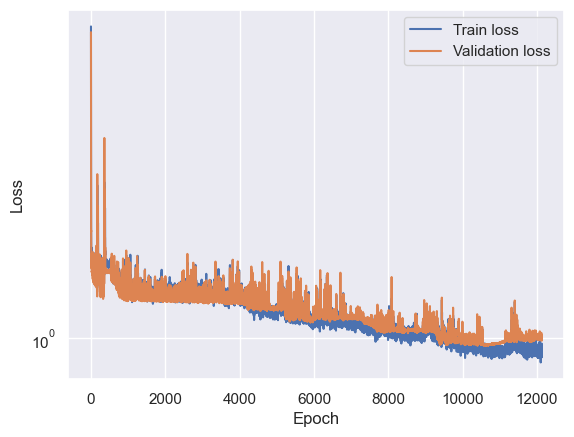

In [306]:
# Plot losses
plt.plot(train_losses, label="Train loss")
plt.plot(val_losses, label="Validation loss")
plt.yscale("log")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

In [307]:
# Test model    
test_loss = test_model(model, test_loader, loss_fn, device=device, normalize=normalized_TTF_data)
print("Test loss: ", test_loss)

Test loss:  1.0673885345458984


In [308]:
# Show results
model.eval()
target = []
predicted = []
Vs_data = []
with torch.no_grad():
    for X, y in test_loader:
        X, y = X.to(device), y.to(device)
        y_pred = model(X, device)
        target.append(y.cpu().numpy())
        predicted.append(y_pred.cpu().numpy())
        Vs_data.append(X.cpu().numpy())

target = np.concatenate(target)
predicted = np.concatenate(predicted)
Vs_data = np.concatenate(Vs_data)

# Undo log transformation
if normalized_TTF_data:
    target = denormalization(target)
    predicted = denormalization(predicted)

print(target.shape, predicted.shape, Vs_data.shape)

(15, 1000) (15, 1000) (15, 30, 1)


In [309]:
# Get the correlation factor between target and predicted
from scipy.stats import pearsonr

for i in range(target.shape[0]):
    print("Correlation factor for TTF ", i,"and Vs ", str(Vs_data[i,0,0]), " : ", pearsonr(target[i], predicted[i])[0])

Correlation factor for TTF  0 and Vs  489.579  :  0.7825891222463923
Correlation factor for TTF  1 and Vs  436.673  :  0.6023029575732082
Correlation factor for TTF  2 and Vs  427.054  :  0.5409948429201332
Correlation factor for TTF  3 and Vs  585.772  :  0.8958249830796952
Correlation factor for TTF  4 and Vs  268.337  :  0.3646819513614328
Correlation factor for TTF  5 and Vs  446.293  :  0.7068410422716198
Correlation factor for TTF  6 and Vs  253.908  :  0.6053692950354446
Correlation factor for TTF  7 and Vs  782.966  :  0.665321926782422
Correlation factor for TTF  8 and Vs  720.441  :  0.8819552209405117
Correlation factor for TTF  9 and Vs  407.816  :  0.6443525609320986
Correlation factor for TTF  10 and Vs  302.004  :  0.5926242246979854
Correlation factor for TTF  11 and Vs  143.287  :  0.415236876881071
Correlation factor for TTF  12 and Vs  258.717  :  0.5097000378453203
Correlation factor for TTF  13 and Vs  672.345  :  0.5468880581010467
Correlation factor for TTF  14 a

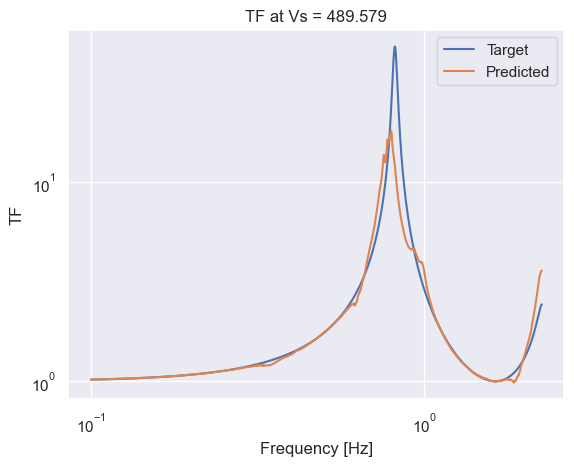

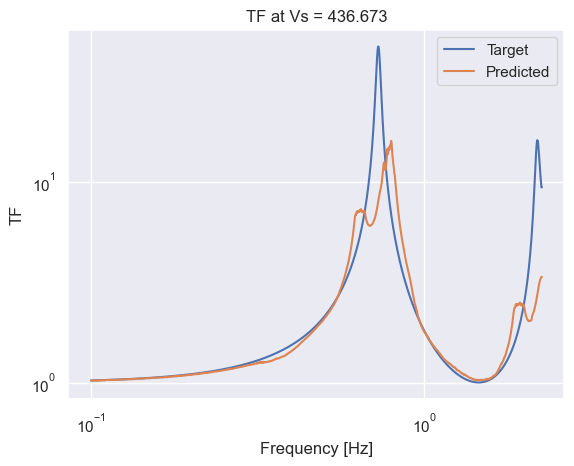

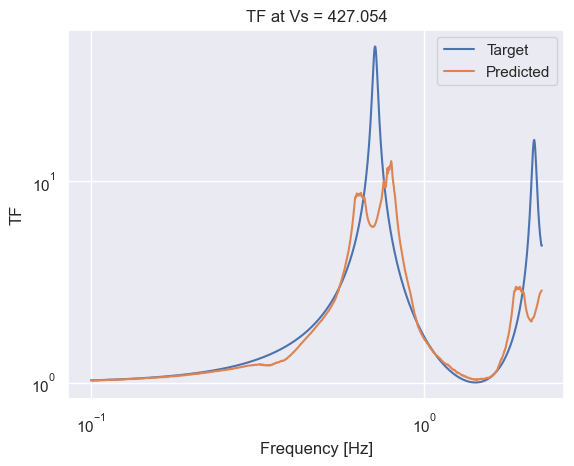

In [310]:
for i in range(target.shape[0]):
    plt.loglog(freq_data, target[i,:], label="Target")
    plt.loglog(freq_data, predicted[i,:], label="Predicted")
    plt.xlabel("Frequency [Hz]")
    plt.ylabel("TF")
    plt.title("TF at Vs = " + str(Vs_data[i,0,0]))
    plt.legend()
    plt.show()

    if i == 2:
        break

# Checking

In [311]:
# Create a lodaer for the whole dataset
all_loader = DataLoader(dataset, batch_size=1, shuffle=False)

correlations = []
Vs_range = []
predicted = []
target = []

with torch.no_grad():
    for X, y in all_loader:
        X, y = X.to(device), y.to(device)
        y_pred = model(X, device)
        if normalized_TTF_data:
            y_pred = denormalization(y_pred)
            y = denormalization(y)
        correlations.append(pearsonr(y.cpu().numpy().flatten(), y_pred.cpu().numpy().flatten())[0])
        Vs_range.append(X.cpu().numpy().flatten()[0])
        predicted.append(y_pred.cpu().numpy().squeeze())
        target.append(y.cpu().numpy().squeeze())

correlations = np.array(correlations)
Vs_range = np.array(Vs_range)
predicted = np.array(predicted)
target = np.array(target)

print(correlations.shape, Vs_range.shape, predicted.shape, target.shape)



(146,) (146,) (146, 1000) (146, 1000)


In [312]:
# Save correlation results

np.savetxt(os.path.join(path,"correlations_try_1.csv"), correlations, delimiter=",")
np.savetxt(os.path.join(path,"Vs_pred_try_1.csv"), predicted, delimiter=",")

np.savetxt(os.path.join(path, "Vs_range_try_1.csv"), Vs_range, delimiter=",")
np.savetxt(os.path.join(path, "TTF_target_try_1.csv"), target, delimiter=",")

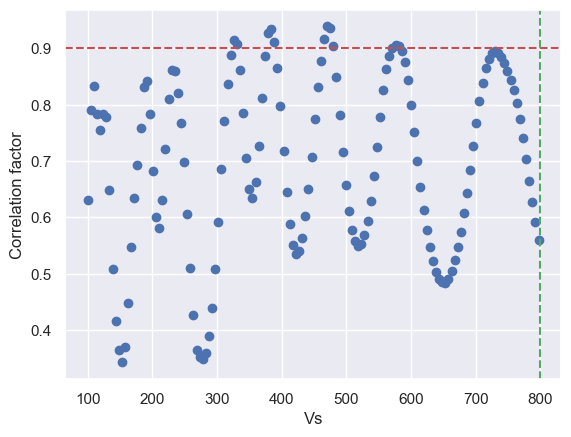

In [313]:
plt.scatter(Vs_range,correlations)
plt.xlabel("Vs")
plt.ylabel("Correlation factor")

# Add horizontal line at 0.9
plt.axhline(y=0.9, color='r', linestyle='--')

# Add vertical transparency after VS = 800
plt.axvline(x=800, color='g', linestyle='--')

#plt.yscale("log")
plt.show()

In [314]:
Vs_range[np.abs(Vs_range - 181.764).argmin()]

181.764

In [315]:
Vs_range.shape

(146,)

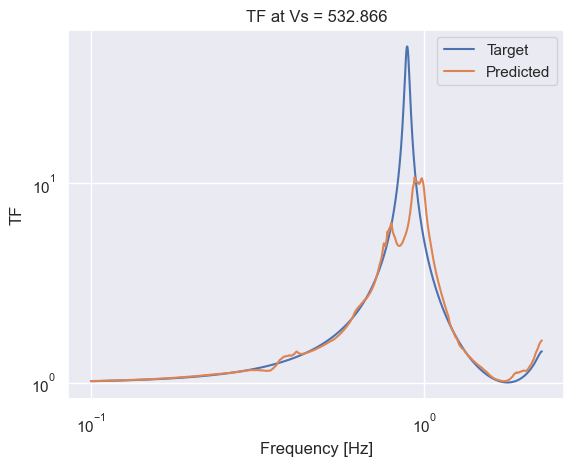

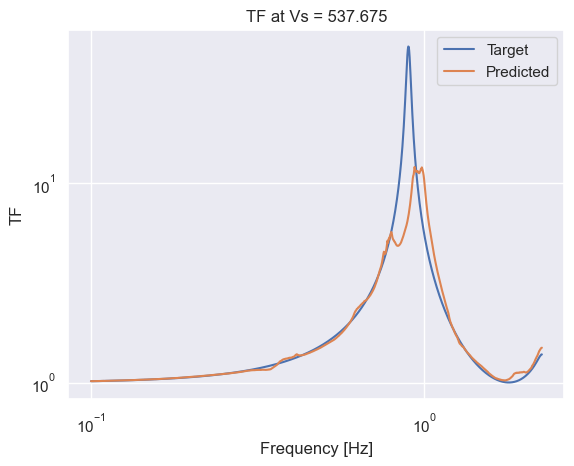

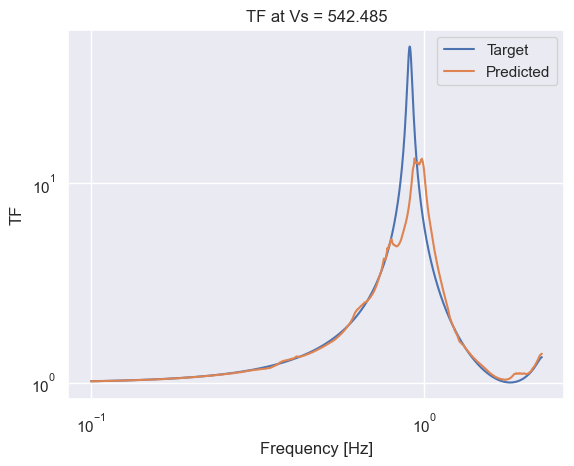

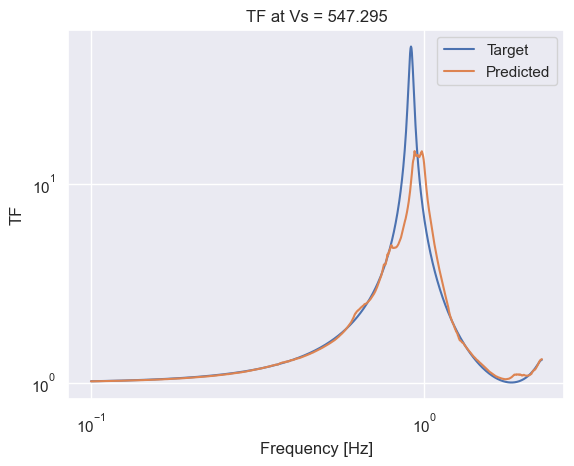

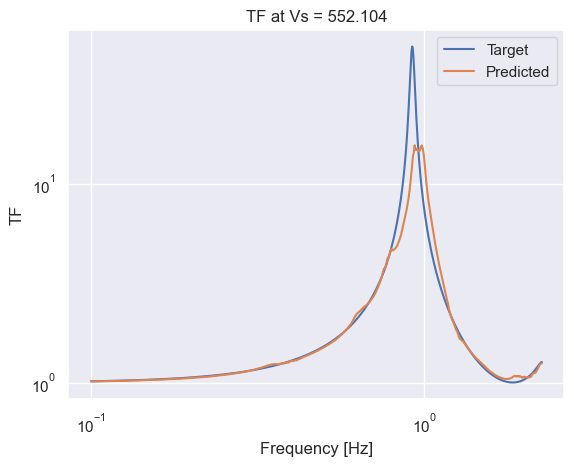

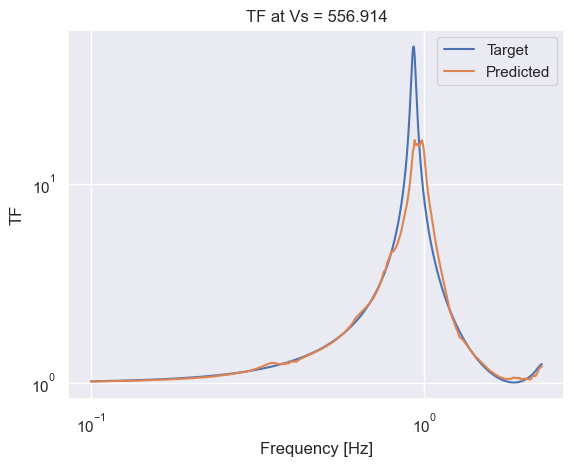

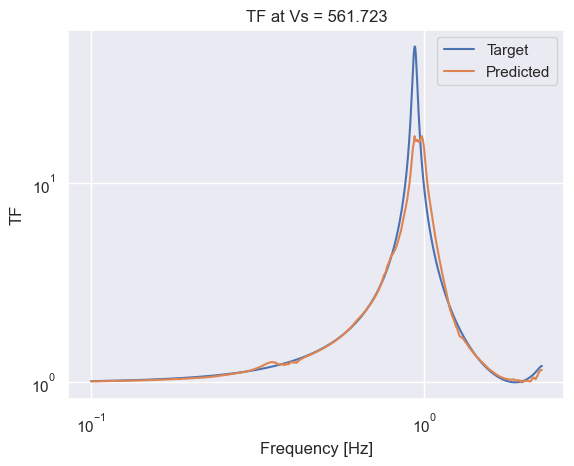

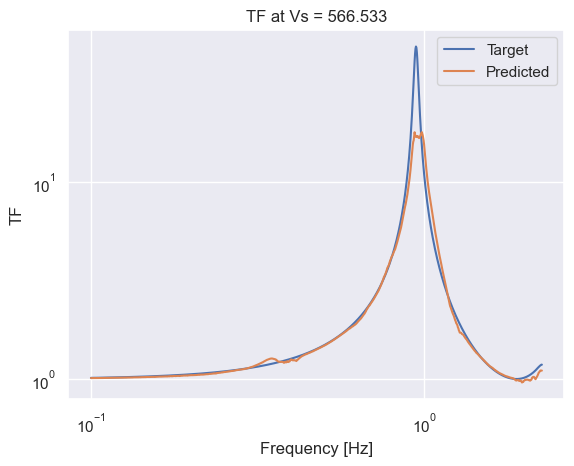

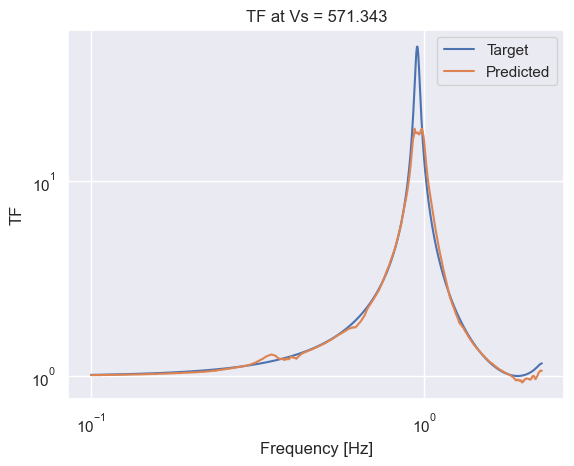

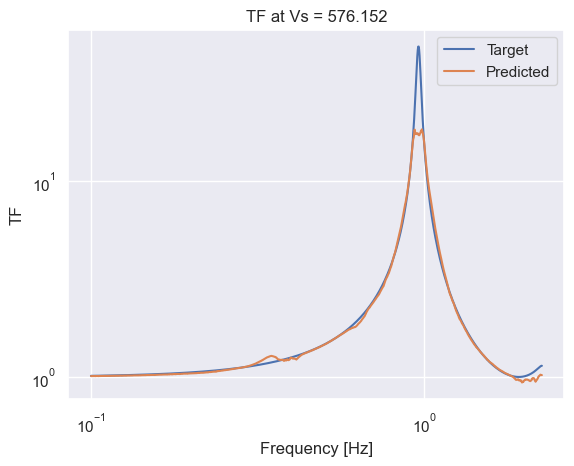

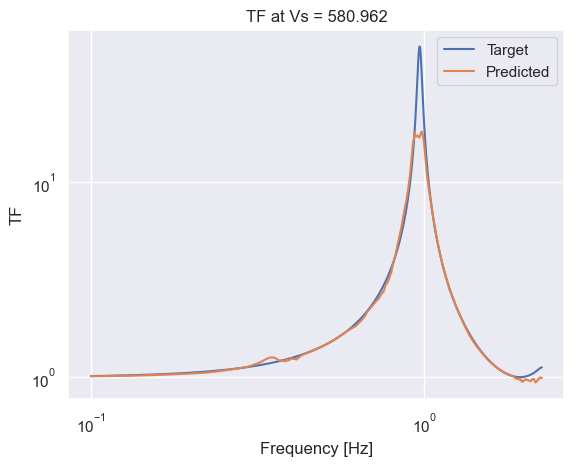

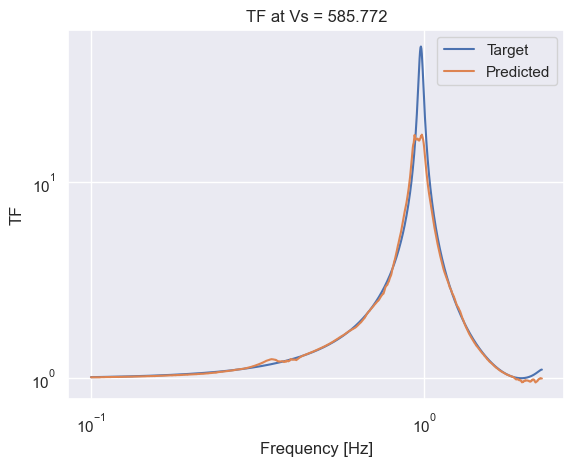

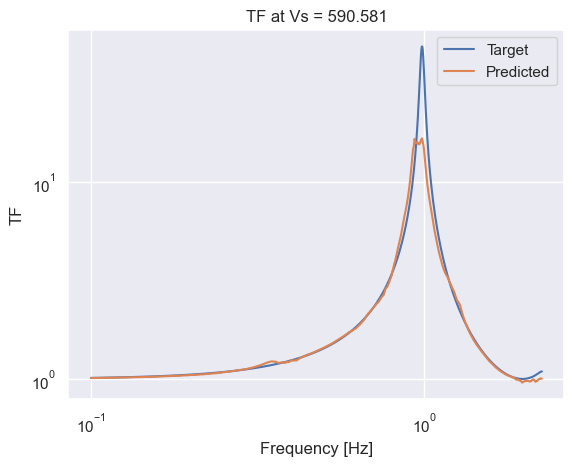

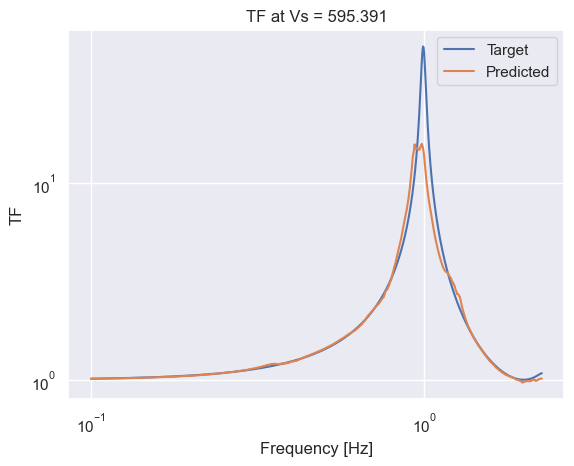

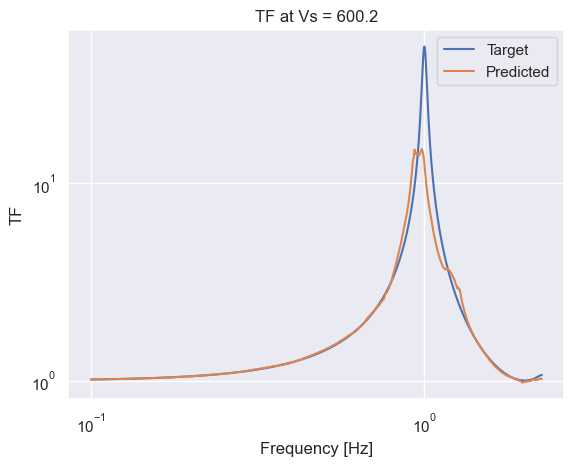

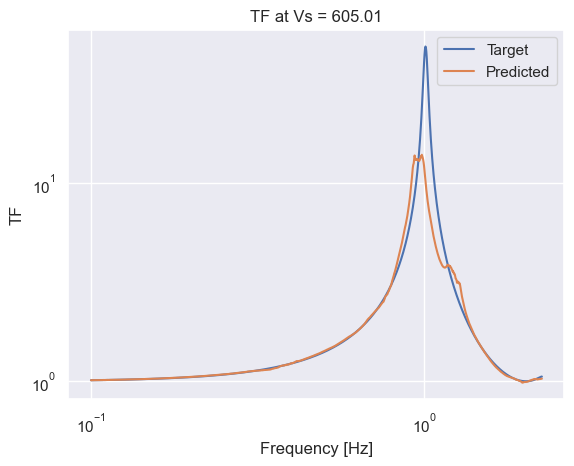

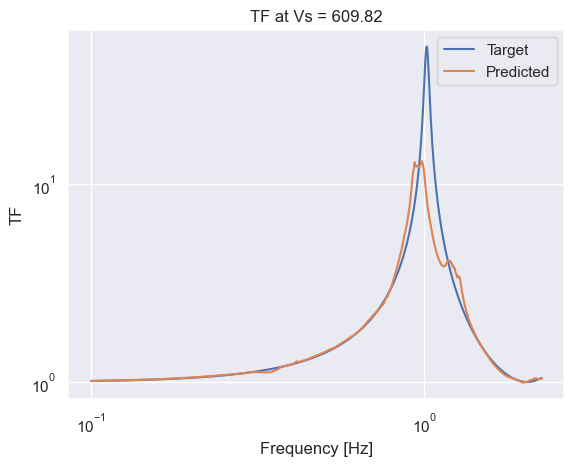

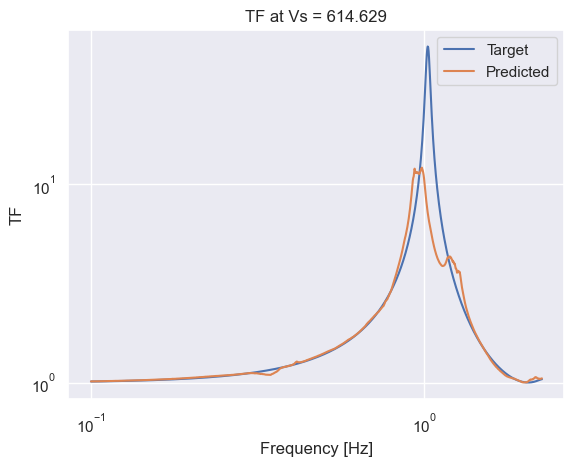

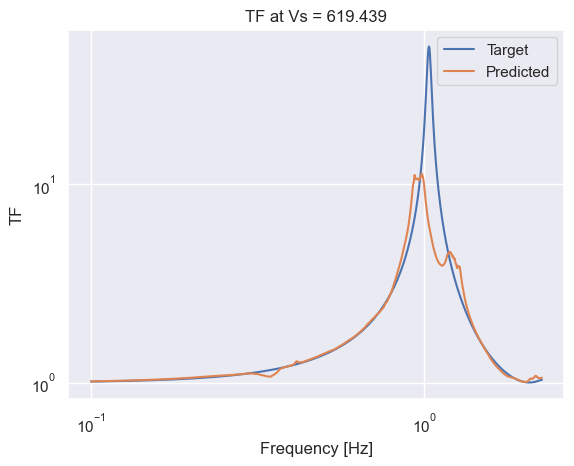

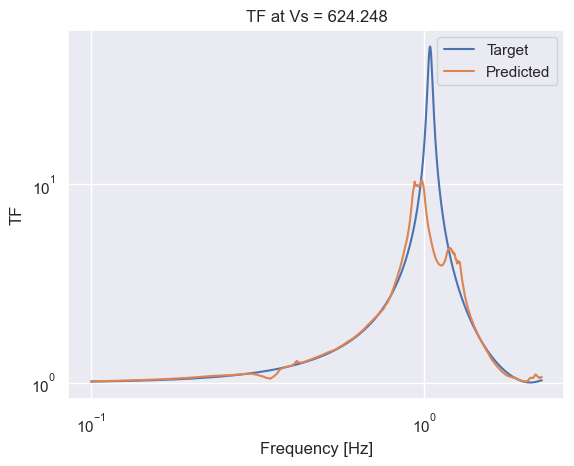

In [316]:
# Plot predicted
for i in range(predicted.shape[0]):

    if Vs_range[i] in Vs_range[90:110]:
        plt.loglog(freq_data, target[i,:], label="Target")
        plt.loglog(freq_data, predicted[i,:], label="Predicted")
        plt.xlabel("Frequency [Hz]")
        plt.ylabel("TF")
        plt.title("TF at Vs = " + str(Vs_range[i]))
        plt.legend()
        plt.show()

In [317]:
# Save model
#torch.save(model.state_dict(), os.path.join(r"FLAC\FLAC2D\1D 1 Column\model_save","model_CNN_RNN_1000_log_norm.pt"))

In [318]:
# 